<a href="https://colab.research.google.com/github/tbonne/peds/blob/main/docs/introComm/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
  <img src="https://raw.githubusercontent.com/tbonne/peds/main/images/best-mobile-games.jpg" width="500" alt="colab">
</p>

***

## <font color='darkorange'>A/B Testing</font>

Here we will look at how to collect and analyze data to determine the difference between two groups. The idea here is that if we randomly assign individuals to two groups we end up with comparable groups. If we then measure how these two groups respond to a treatment (e.g., being given game version A vs. game version B) we can better determine the effect of that treatment.


We'll take a look at data collected to test how effective different versions of a game are at retaining users.




In [1]:
#load packages
import pandas as pd
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Load the data

In [33]:
#load data
df_cats = pd.read_csv("/content/cookie_cats.csv")

#take a look
df_cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### <font color='darkorange'>Describe the data</font>

How many in each group?

In [34]:
df_cats.version.value_counts()

,count
version,
gate_40,45489
gate_30,44700


How many users returned after 7 days?

In [38]:
#gate placed at level 30
df_cats.groupby("version")["retention_7"].mean()

,retention_7
version,
gate_30,0.190201
gate_40,0.182000


### <font color='darkorange'>Visualize the data</font>

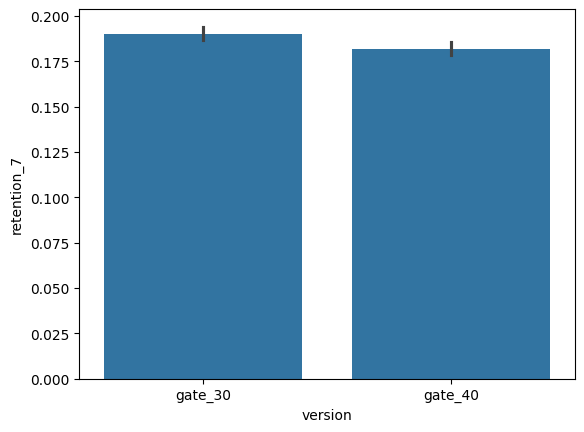

In [39]:
#plot the differences between the versions
sns.barplot(data=df_cats, x="version", y="retention_7")
plt.show()

### <font color='darkorange'>Wrangle the data</font>

Convert the binary traget and binary input variable to 0/1

In [40]:
from sklearn.preprocessing import LabelEncoder

#build the encoder
le_retention7 = LabelEncoder()
le_version = LabelEncoder()

#fit and transform the gender column
df_cats['retention_7'] = le_retention7.fit_transform(df_cats['retention_7'])
df_cats['version'] = le_version.fit_transform(df_cats['version'])

#take a look
df_cats

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,0,3,False,0
1,337,0,38,True,0
2,377,1,165,True,0
3,483,1,1,False,0
4,488,1,179,True,1
...,...,...,...,...,...
90184,9999441,1,97,True,0
90185,9999479,1,30,False,0
90186,9999710,0,28,True,0
90187,9999768,1,51,True,0


In [53]:
le_retention7.classes_

array([False,  True])

In [52]:
le_version.classes_

array(['gate_30', 'gate_40'], dtype=object)

Split your data into training and testing

In [75]:
#split data into predictors (X) and target (y)
X = df_cats.drop(['retention_7','retention_1','userid','sum_gamerounds'], axis=1)
y = df_cats['retention_7']

#split these data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

### <font color='darkorange'>Build a model</font>

Can we predict which game version does better?

* Note: given the large class imbalance let's make the model more sensitive to errors in the minority class. So, as class 1 (i.e., making it to 7 days) is rare, errors in predicting class 1 will "hurt" the model more. It does this by changing the loss function (something we have not covered in this class but you will be seeing more of in later classes!).

In [100]:
from sklearn.ensemble import RandomForestClassifier

#1. build the algorithm
classifier = RandomForestClassifier(class_weight="balanced")

#2. fit the algorithm to the data
classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced')

Check how your model does on the test data

Text(50.722222222222214, 0.5, 'True label')

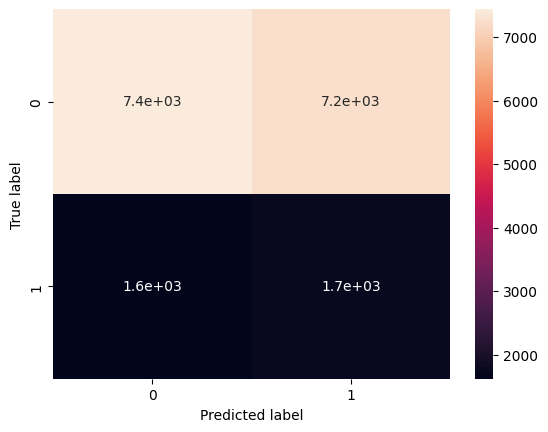

In [101]:
from sklearn.metrics import confusion_matrix

#predict on testing data
y_pred = classifier.predict(X_test)

#create a confusion matrix
cm_logit = confusion_matrix(y_test, y_pred)

#visualize the confusion matrix
sns.heatmap(cm_logit, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model_acc = accuracy_score(y_test, y_pred)
model_prec = precision_score(y_test, y_pred)
model_rec = recall_score(y_test, y_pred)

print(f"accuracy: {model_acc:.2f}" )
print(f"precision: {model_prec:.2f}" )
print(f"recall: {model_rec:.2f}" )

accuracy: 0.51
precision: 0.19
recall: 0.52


Not great! This suggests that the version a user is playing is not likely to have a big impact on wether they play for more than 7 days.

Let's estimate how the model thinks the probability of making it to more than 7 days is impacted by the version.

In [110]:
#1. Create a dataframe
df_question = pd.DataFrame({'version':[0,1]})

#2. Use the model to make predictions
question_pred =  classifier.predict_proba(df_question)

#3. Take a look at the answer
question_pred


array([[0.49449892, 0.50550108],
       [0.50534892, 0.49465108]])

Now we can calculate the difference in probabilities

In [111]:
question_pred[0,1] - question_pred[1,1]

np.float64(0.01085000301680944)

This is known as the average treatment effect, i.e., how much does the treatment (versions) impact the outcome on average.

As a final step, if presenting this information to someone, it's a good idea to quantify an estimate of the uncertainty around the effect. Let's do that below with a bootstrapping.

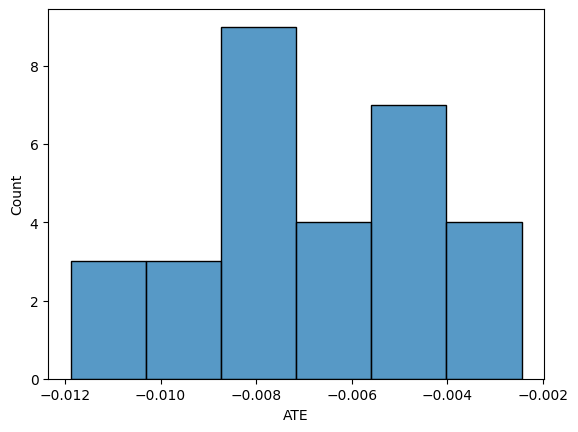

In [107]:
import numpy as np
from sklearn.utils import resample

n_bootstraps = 30
ates = []

for _ in range(n_bootstraps):
    # resample data
    X_b, y_b = resample(X_train, y_train, replace=True)
    clf = RandomForestClassifier().fit(X_b, y_b)

    # predict prob for version=0 and version=1
    df_question = pd.DataFrame({'version':[0,1]})
    probs = clf.predict_proba(df_question)
    ate = probs[1,1] - probs[0,1]
    ates.append(ate)

sns.histplot(ates)
plt.xlabel("ATE")
plt.show()

The histogram shows us the distribution of average treatment effects. Let's summarize this distribution to make it easier to communicate. Let's get the mean and the confidence intervals of the estimate.

In [109]:
print(f"ATE: {np.mean(ates):.3f}")

ci_lower, ci_upper = np.percentile(ates, [2.5, 97.5])
print(f"ATE 95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")


ATE: -0.007
ATE 95% CI: (-0.011, -0.003)


<p align="left">
  <img src="https://raw.githubusercontent.com/tbonne/peds/main/images/take_action.jpg" width="100" alt="colab">
</p>

> Try redoing the exercise above without the increased penalty for the minority class: e.g., remove class_weight="balanced". How do the results change?

> If time permits, try redoing the exercise with sum_game_rounds instead of retention_7. Do you come to the same conclusion about which version is better?

### <font color='darkorange'>Bonus</font>


> Try redoing the exercise above with a linear regression approach. You can use a scikit-learn LinearRegression or you can use smf which gives more statistical outputs.

> How do the results differ or remain the same?

In [ ]:
import statsmodels.api as sm #for running regression!
import statsmodels.formula.api as smf

#split these data into training and testing datasets
# for smf we need to have retention_7 and version in a data frame
df_cats_train, df_cats_test = train_test_split(df_cats, test_size=0.20, stratify=df_cats['retention_7'])

#1. Build the model
linear_reg_model = smf.logit(formula='retention_7 ~ version ', data=df_cats_train)

#2. Use the data to fit the model (i.e., find the best intercept and slope parameters)
linear_reg_model.fit()

#3. take a look at the summary
linear_reg_model.summary()

### <font color='darkorange'>Further reading</font>

> If you would like the notebook without missing code check out the [full code](https://colab.research.google.com/github/tbonne/peds/blob/main/docs/fullNotebooks/full_A_B_Testing.ipynb) version.